In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.preprocessing import *     # Import all the preprocessing methods
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit
from sklearn.metrics import roc_curve, auc, roc_auc_score, log_loss, balanced_accuracy_score, accuracy_score, precision_recall_curve, average_precision_score, confusion_matrix, mean_squared_error, mean_absolute_percentage_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LogisticRegression
import xgboost as xgb
import numpy as np
import sys, pickle,itertools
import shap
from sklearn.model_selection import train_test_split, TimeSeriesSplit
plt.rcParams["figure.figsize"] = (10,7)

import pickle

import warnings
warnings.filterwarnings('ignore')

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [13]:
train_set = pd.read_csv('./data/train_df_expanded_KNN_imp_feats.csv')
train_set = train_set.replace([np.inf, -np.inf], np.nan)

with open("./output/y_train3_clf_preds.pkl", "rb") as f:
    y_pred_class = pickle.load(f)

x_testing = train_set.copy(deep=True)

x_testing['Class']=y_pred_class

cm = confusion_matrix(x_testing['Target > 2'],x_testing['Class'])

cm



array([[26286,    73],
       [   47,  1052]], dtype=int64)

No handles with labels found to put in legend.


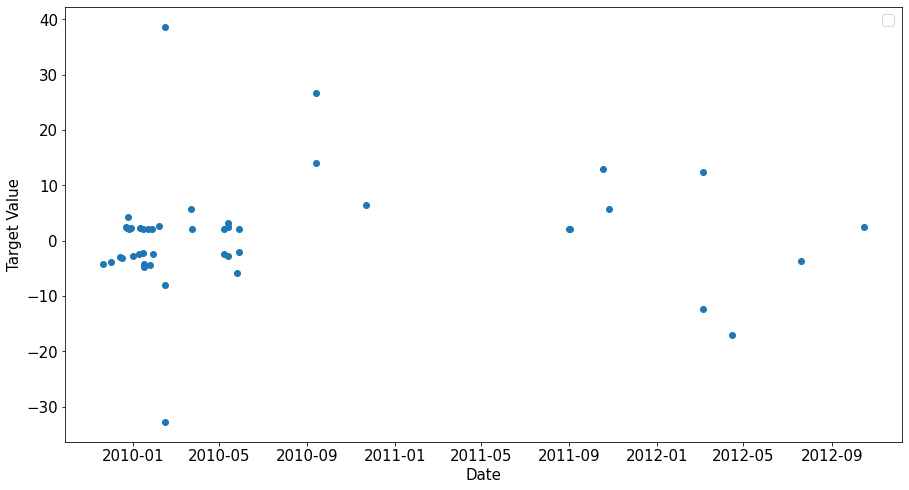

In [14]:
x_testing['Date']=pd.to_datetime(x_testing['Date'])
plt.figure(figsize=(15,8))
plt.scatter(x_testing[(x_testing['Target > 2']==1) & (x_testing['Class']==0)]['Date'], x_testing[(x_testing['Target > 2']==1) & (x_testing['Class']==0)]['Target'])
plt.xlabel('Date')
plt.ylabel('Target Value')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()


In [15]:
reg=xgb.Booster()
reg.load_model('./output/Reg_predicted_labels.json')

x_testing=x_testing[(x_testing['Target > 2']==1) & (x_testing['Class']==0)]
y_testing=x_testing['Target']

x_testing = x_testing[reg.feature_names]

d_testing=xgb.DMatrix(x_testing, y_testing)

pred_class_error=reg.predict(d_testing)

No handles with labels found to put in legend.


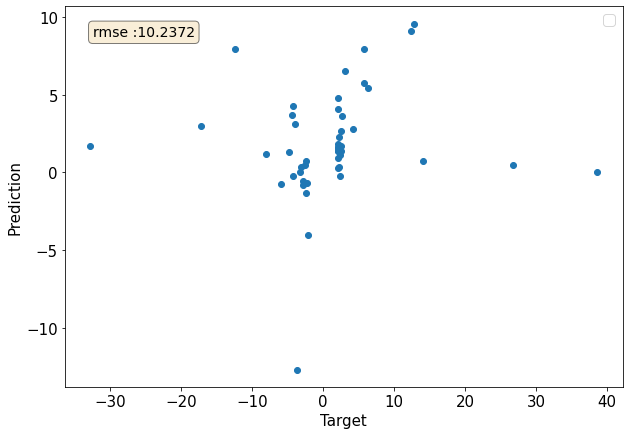

In [16]:
rmse_class_error = np.sqrt(mean_squared_error(y_testing, pred_class_error))
plt.scatter(y_testing, pred_class_error)
textstr = 'rmse :' + str(rmse_class_error.round(4))
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
plt.text(0.05, 0.95, textstr, transform=plt.gca().transAxes, fontsize=14,
         verticalalignment='top', bbox=props)
plt.xlabel('Target')
plt.ylabel('Prediction')
plt.rcParams.update({'font.size': 15})
plt.legend()
plt.show()

In [23]:
y_testing.reset_index(drop=True).iloc[23]

38.655199

In [27]:
y_train = train_set['Target']
x_train = train_set.drop(['Date', 'Target','Abs Target','Target > 2'], axis=1)
    
x_train = x_train[reg.feature_names]
x_train['Class']=y_pred_class

explainer = shap.TreeExplainer(reg)
shap_values = explainer(x_testing)

true40=x_train.drop(columns=['Class']).iloc[[4238]].T
example=x_testing.iloc[[23]].T
means=x_train[x_train['Class']==1].drop(columns=['Class']).mean().T
shap_values2 = explainer(x_train[x_train['Class']==1].drop(columns=['Class']))
example=example.reset_index().rename(columns={3275:'False high Value'})
example['Shap impact False high']=shap_values[23].values

example=example.rename(columns={'index':'Features'})

true40=true40.reset_index().rename(columns={4238:'True high Value','index':'Features'})
true40['Shap impact True high']=shap_values2[276].values
example=example.merge(true40,on=['Features'])

In [28]:
example.sort_values(['Shap impact True high'],ascending=False)

,Features,False high Value,Shap impact False high,True high Value,Shap impact True high
3,Avg_CCS1_WHCO2InjPs_psi_diff1,-2.793625,0.256342,1302.711877,11.655196
10,Avg_CCS1_WHCO2InjPs_psi_pct_change1,-0.002534,2.153897,NaN,5.708593
4,Avg_CCS1_WHCO2InjTp_F_lag1,80.732462,0.220311,0.000000,4.586085
13,Avg_CCS1_WHCO2InjTp_F_diff1,-0.161511,-0.220111,95.553879,2.643117
16,Avg_CCS1_DH6325Ps_psi_diff1,-9.951215,-0.293291,-0.294719,2.632650
8,Avg_CCS1_WHCO2InjTp_F_pct_change1,-0.002001,-0.065340,NaN,1.711510
1,Avg_CCS1_DH6325Ps_psi_pct_change1,-0.003025,-0.921192,-0.000091,1.370582
9,Avg_CCS1_DH6325Ps_psi_pct_change2,-0.002924,-0.024919,0.000849,1.195470
6,Avg_CCS1_WHCO2InjPs_psi,1099.778038,-0.243055,1302.711877,1.116126
18,Avg_CCS1_DH6325Ps_psi,3280.075168,0.263499,3252.473927,1.095933
